### Quantify performance of trained model ###

In [60]:
import os
import ast
import re
import numpy as np
import pandas as pd
import logging
import glob
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import patches

# PyTorch and HuggingFace Transformers
import torch
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

logger = logging.getLogger(name=__name__)

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.dentexdata import DentexData
from detection.detrdataset import get_gpu_info, DetectionDatasetFromDF
from detection.fileutils import FileOP
from detection.imageproc import ImageData, xyxy2xywh, xywh2xyxy, clipxywh
from detection.imageproc import determine_bbox_format

print(f'Project module version: {dt.__version__}')
print(f'PyTorch version:        {torch.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.1.post1.dev31+g14d1a25.d20250315
PyTorch version:        2.6.0a0+ecf3bae40a.nv25.01


In [5]:
# Check GPU availability
device, device_str = get_gpu_info()

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.6.0a0+ecf3bae40a.nv25.01
CUDA version:      12.8
CUDNN version:     90700


### Helper functions ###

In [78]:
# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, box_list, label_list=None, alpha=0.7, edgecolor=None, ax=None):
    color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for b, box in enumerate(box_list):
        if edgecolor is None:
            boxcolor = color_list[b]
        else:
            boxcolor = edgecolor
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=2.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0]+width/2, y=anchor[1]-3, s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

def get_iou(true_bbox, pred_bbox, bbox_format='xyxy'):
    ''' Calculate IoU for bounding boxes in xyxy format (upper left corner, lower right corner) '''
    # Check bounding box format
    assert determine_bbox_format(true_bbox)==bbox_format, f'true_bbox: format is not consistent with "{bbox_format}"'
    assert determine_bbox_format(pred_bbox)==bbox_format, f'pred_bbox: format is not consistent with "{bbox_format}"'
    ground_truth, pred = true_bbox, pred_bbox
    if bbox_format == 'xywh':
        ground_truth, pred = xywh2xyxy(true_bbox), xywh2xyxy(pred_bbox)
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
     
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
     
    area_of_intersection = i_height * i_width
     
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
     
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
     
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
     
    iou = area_of_intersection / area_of_union
     
    return iou

In [7]:
# Directories and files
data_dir = os.path.join(os.environ.get('HOME'), 'data', 'dentex_detection')
image_dir = os.path.join(data_dir, 'quadrants')

# Model directory
model_name = 'rtdetr_250311_06'
model_dir = os.path.join(data_dir, 'models', model_name)

# Log file
log_file_name = 'train_log_250311.log'
log_file = os.path.join(model_dir, log_file_name)

# Output for the images with the predictions
output_dir = os.path.join(model_dir, 'testresults')
Path(output_dir).mkdir(parents=True, exist_ok=True)

dataset_df_file_name = 'train_split_250224.parquet'
dataset_df_file = os.path.join(image_dir, dataset_df_file_name)
df = pd.read_parquet(dataset_df_file)
display(df.head(2))

# convert class id to ada position
ada_list = sorted(list(df['ada'].unique()))
id2label = dict(zip(range(len(ada_list)), ada_list))
label2id = {v: k for k, v in id2label.items()}

,file_name,quadrant,pos,bbox,segmentation,fdi,ada,dset
0,train_0_1.png,1,1,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",11,8,train
1,train_0_1.png,1,2,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",12,7,train


In [8]:
# Load the log file
with open(log_file, mode='r') as fl:
    log = fl.read()
print(log)

250311-21:25-__main__-INFO-{"output_dir": "/app/data/dentex_detection/model/rtdetr_250311_06", "num_train_epochs": 500, "max_grad_norm": 0.1, "learning_rate": 1e-05, "warmup_steps": 300, "per_device_train_batch_size": 48, "dataloader_num_workers": 8, "metric_for_best_model": "eval_map", "greater_is_better": true, "load_best_model_at_end": true, "eval_strategy": "epoch", "save_strategy": "epoch", "save_total_limit": 5, "remove_unused_columns": false, "eval_do_concat_batches": false}
250311-21:25-__main__-INFO-{"model_version": 6, "model_name": "rtdetr_250311_06", "hf_checkpoint": "PekingU/rtdetr_v2_r101vd", "use_transform": "transform_1"}



In [9]:
# Load the model from checkpoint
hf_model_name = 'PekingU/rtdetr_v2_r101vd'
processor = RTDetrImageProcessor.from_pretrained(hf_model_name)
checkpoint_name = 'checkpoint-10140'
checkpoint_file = os.path.join(model_dir, checkpoint_name)
model = RTDetrV2ForObjectDetection.from_pretrained(checkpoint_file).to(device)

### Ground truth bounding boxes ###

,file_name,quadrant,pos,bbox,segmentation,fdi,ada,dset
17860,train_131_4.png,4,1,"[707, 24, 67, 329]","[[707, 34, 739, 24, 772, 40, 767, 104, 774, 34...",41,25,test
17861,train_131_4.png,4,2,"[647, 37, 73, 334]","[[669, 37, 720, 50, 718, 95, 712, 212, 716, 37...",42,26,test
17862,train_131_4.png,4,3,"[564, 18, 108, 392]","[[615, 18, 659, 31, 672, 85, 661, 141, 649, 19...",43,27,test
17863,train_131_4.png,4,4,"[487, 18, 123, 396]","[[518, 55, 545, 18, 584, 25, 590, 52, 610, 58,...",44,28,test
17864,train_131_4.png,4,5,"[422, 22, 121, 334]","[[454, 31, 488, 22, 510, 40, 527, 37, 543, 70,...",45,29,test
17865,train_131_4.png,4,6,"[282, 19, 194, 361]","[[330, 50, 359, 19, 383, 27, 392, 40, 404, 31,...",46,30,test
17866,train_131_4.png,4,7,"[118, 10, 246, 335]","[[199, 98, 210, 62, 224, 27, 264, 10, 281, 31,...",47,31,test
17867,train_131_4.png,4,8,"[10, 33, 191, 256]","[[58, 105, 60, 73, 83, 44, 99, 41, 119, 33, 14...",48,32,test


[[707, 24, 67, 329], [647, 37, 73, 334], [564, 18, 108, 392], [487, 18, 123, 396], [422, 22, 121, 334], [282, 19, 194, 361], [118, 10, 246, 335], [10, 33, 191, 256]]


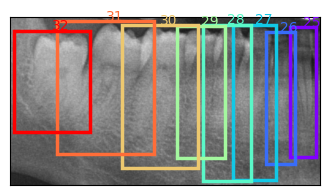

In [33]:
image_idx = 3
figsize = (4, 4)
file_name = df.loc[df['dset'] == 'test', 'file_name'].tolist()[image_idx]
file_base_name = os.path.splitext(file_name)[0]
file = os.path.join(image_dir, file_name)
df_file = df.loc[df['file_name'] == file_name]


# Load the image
im = ImageData().load_image(file)
xlim, ylim = (0, im.shape[1]), (0, im.shape[0])

display(df_file)
box_list = df_file['bbox'].to_list()
ada_list = df_file['ada'].to_list()
box_list = [clipxywh(list(box), xlim=xlim, ylim=ylim, decimals=0) for box in box_list]
print(box_list)

# Show the image
fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, 
                           box_list=box_list, 
                           label_list=ada_list, 
                           alpha=1, 
                           ax=ax)
plt.show()

### Predicted bounding boxes ###

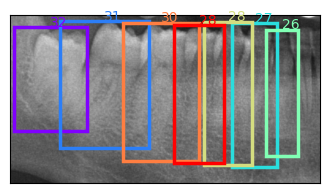

In [11]:
# Process the image to create the input for the model
im_input = processor(im, return_tensors='pt').to(device)
# Run the image through the model
with torch.no_grad():
    model_output = model(**im_input)
# Post-processing: Non-Maximum Suppression (NMS)
threshold = 0.3
results = processor.post_process_object_detection(model_output, 
                                                  target_sizes=torch.tensor([(im.shape[0], im.shape[1])]), 
                                                  threshold=threshold)

output_boxes = results[0].get('boxes').cpu().numpy()
output_boxes = [clipxywh(xyxy2xywh(list(box)), xlim=xlim, ylim=ylim, decimals=0) for box in output_boxes]
output_scores = results[0].get('scores').cpu().numpy()
output_scores = [np.round(score, decimals=3) for score in output_scores]
output_ids = results[0].get('labels').cpu().numpy()
output_ada = [id2label.get(i) for i in output_ids]

# Plot the image with the predicted bounding boxes
fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, 
                           box_list=output_boxes, 
                           label_list=output_ada, 
                           alpha=1, 
                           ax=ax)

### Intersection Over Union IoU ###

In [86]:
predicted_labels = sorted(output_ada)
print(f'Predicted labels: {predicted_labels}')

# Select a predicted bounding box
cl = 30
pidx = output_ada.index(cl)
pred_label = output_ada[pidx]
pred_bbox = output_boxes[pidx]
torch_pred_bbox = torch.tensor(pred_bbox, dtype=torch.float)
pred_score = output_scores[pidx]
print()
print(f'Predicted label: {pred_label}')
print(f'Predicted score: {pred_score}')
print(f'Predicted bbox:  {pred_bbox}')

# Select a ground truth bounding box
# Ground truth index
tidx = 0
true_label = ada_list[tidx]
true_bbox = box_list[tidx]
print()
print(f'True label:     {true_label}')
print(f'Trie bbox:      {true_bbox}')

# Calculate the IoU for the two bounding boxes
numpy_iou = get_iou(true_bbox=true_bbox, pred_bbox=pred_bbox, bbox_format='xywh')
torch_iou = 

# Let's plot the two bounding boxes 
output_file_name = f'{file_base_name}_T{str(true_label).zfill(2)}P{str(predicted_label).zfill(2)}.png'
output_file = os.path.join(output_dir, output_file_name)
figsize = (5, 5)
plot_box_list = [true_bbox, predicted_bbox]
plot_lab_list = ['T', 'P']

fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, 
                           box_list=plot_box_list, 
                           label_list=plot_lab_list, 
                           alpha=1, 
                           ax=ax)
ax.set_title(f'IoU: {iou: .3f}', loc='left')
plt.savefig(output_file, bbox_inches='tight')
plt.show()

SyntaxError: invalid syntax (1811606234.py, line 27)